FIRST Rebuilding Model, explicitly explaining Linear layers to better transfer over to be compatible for quantization

Epoch 1, Batch 0, Loss: 2.2873
Epoch 1, Batch 100, Loss: 0.2432
Epoch 1, Batch 200, Loss: 0.1135
Epoch 1, Batch 300, Loss: 0.1010
Epoch 1, Batch 400, Loss: 0.0903
Epoch 1, Batch 500, Loss: 0.1016
Epoch 1, Batch 600, Loss: 0.2505
Epoch 1, Batch 700, Loss: 0.0401
Epoch 1, Batch 800, Loss: 0.0194
Epoch 1, Batch 900, Loss: 0.0590
✅ Epoch 1 complete | Avg Loss: 0.1826
Epoch 2, Batch 0, Loss: 0.1533
Epoch 2, Batch 100, Loss: 0.1002
Epoch 2, Batch 200, Loss: 0.0317
Epoch 2, Batch 300, Loss: 0.1792
Epoch 2, Batch 400, Loss: 0.0531
Epoch 2, Batch 500, Loss: 0.0769
Epoch 2, Batch 600, Loss: 0.0948
Epoch 2, Batch 700, Loss: 0.0260
Epoch 2, Batch 800, Loss: 0.0832
Epoch 2, Batch 900, Loss: 0.0599
✅ Epoch 2 complete | Avg Loss: 0.0654
Epoch 3, Batch 0, Loss: 0.0205
Epoch 3, Batch 100, Loss: 0.0125
Epoch 3, Batch 200, Loss: 0.0409
Epoch 3, Batch 300, Loss: 0.0182
Epoch 3, Batch 400, Loss: 0.0175
Epoch 3, Batch 500, Loss: 0.0103
Epoch 3, Batch 600, Loss: 0.0337
Epoch 3, Batch 700, Loss: 0.1118
Epoch 

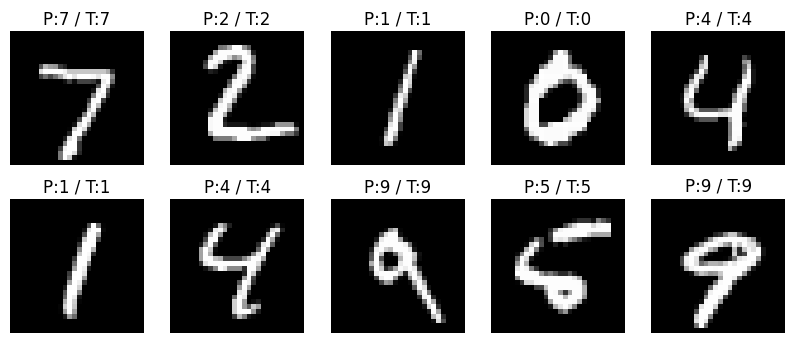

✅ Model saved to mnist_cnn_clean.pt (quantization-ready)


In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

# ✅ 1. Define the quantization-compatible model
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ✅ 2. Load MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

# ✅ 3. Training setup
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ConvNet().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ✅ 4. Train the model
for epoch in range(10):
    model.train()
    total_loss = 0

    for batch, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch % 100 == 0:
            print(f"Epoch {epoch+1}, Batch {batch}, Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    print(f"✅ Epoch {epoch+1} complete | Avg Loss: {avg_loss:.4f}")

# ✅ 5. Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        predicted = pred.argmax(dim=1)
        correct += (predicted == y).sum().item()
        total += y.size(0)

accuracy = 100 * correct / total
print(f"🎯 Test Accuracy: {accuracy:.2f}%")

# ✅ 6. Visualize predictions (first 10)
images, labels = next(iter(test_loader))
images = images.to(device)
outputs = model(images)
preds = outputs.argmax(dim=1)

plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i].cpu().squeeze(), cmap='gray')
    plt.title(f"P:{preds[i].item()} / T:{labels[i].item()}")
    plt.axis('off')
plt.show()

# ✅ 7. Save the trained model (for quantization)
model.to("cpu")
torch.save(model.state_dict(), "mnist_cnn_clean.pt")
print("✅ Model saved to mnist_cnn_clean.pt (quantization-ready)")


QUANTIZATION STEP

In [31]:
import torch
import torch.nn as nn

# Reuse the same ConvNet class
model = ConvNet()
model.load_state_dict(torch.load("mnist_cnn_clean.pt", map_location="cpu"))
model.eval()

# Apply dynamic quantization (targeting Linear layers only)
quantized_model = torch.quantization.quantize_dynamic(
    model, {nn.Linear}, dtype=torch.qint8
)

/tmp/ipython-input-1364863828.py:10: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_model = torch.quantization.quantize_dynamic(


COMPARING MODEL PERFORMANCE

In [32]:
correct = 0
total = 0

with torch.no_grad():
    for X, y in test_loader:
        outputs = quantized_model(X)
        predicted = outputs.argmax(dim=1)
        correct += (predicted == y).sum().item()
        total += y.size(0)

accuracy = 100 * correct / total
print(f"✅ Quantized Model Accuracy: {accuracy:.2f}%")


✅ Quantized Model Accuracy: 99.30%


SIZE REDUCTION COMPARISON

In [33]:
import os

torch.save(model.state_dict(), "mnist_original.pt")
torch.save(quantized_model.state_dict(), "mnist_quantized.pt")

original_size = os.path.getsize("mnist_original.pt") / 1024
quantized_size = os.path.getsize("mnist_quantized.pt") / 1024

print(f"📦 Original: {original_size:.2f} KB")
print(f"📦 Quantized: {quantized_size:.2f} KB")
print(f"💡 Reduction: {100 * (original_size - quantized_size) / original_size:.2f}%")


📦 Original: 1650.80 KB
📦 Quantized: 472.45 KB
💡 Reduction: 71.38%


EXPORTING TO ONNX

In [34]:
import torch

dummy_input = torch.randn(1, 1, 28, 28)


In [38]:
model = ConvNet()
model.load_state_dict(torch.load("mnist_cnn_clean.pt", map_location="cpu"))
model.eval()

dummy_input = torch.randn(1, 1, 28, 28)

torch.onnx.export(
    model,                      # full-precision model
    dummy_input,
    "mnist.onnx",
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
    opset_version=12
)

print("✅ Full-precision model exported to mnist.onnx")

✅ Full-precision model exported to mnist.onnx


/tmp/ipython-input-436393442.py:7: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


In [42]:
from onnxruntime.quantization import quantize_dynamic, QuantType

quantize_dynamic(
    model_input="mnist.onnx",
    model_output="mnist_quantized_linear.onnx",
    weight_type=QuantType.QInt8,
    op_types_to_quantize=["MatMul", "Add"]  # only quantize linear ops
)

print("✅ Re-quantized with linear ops only → mnist_quantized_linear.onnx")

✅ Re-quantized with linear ops only → mnist_quantized_linear.onnx


In [43]:
import os

original_size = os.path.getsize("mnist.onnx") / 1024
quantized_size = os.path.getsize("mnist_quantized.onnx") / 1024

print(f"📦 Original ONNX model: {original_size:.2f} KB")
print(f"📦 Quantized ONNX model: {quantized_size:.2f} KB")
print(f"💡 Size reduction: {100 * (original_size - quantized_size) / original_size:.2f}%")


📦 Original ONNX model: 1648.93 KB
📦 Quantized ONNX model: 419.49 KB
💡 Size reduction: 74.56%


In [44]:
import onnxruntime as ort
import numpy as np

# Load new quantized model
session = ort.InferenceSession("mnist_quantized_linear.onnx")

input_name = session.get_inputs()[0].name
X_sample, y_sample = next(iter(test_loader))
sample_input = X_sample[0:1].numpy()

output = session.run(None, {input_name: sample_input})
predicted = np.argmax(output[0])

print(f"🧠 ONNX Prediction: {predicted}")
print(f"🎯 Ground Truth: {y_sample[0].item()}")



🧠 ONNX Prediction: 7
🎯 Ground Truth: 7
